In [12]:
from dotenv import load_dotenv
from typing import Annotated
from langchain_experimental.tools import PythonREPLTool
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal
import functools
import operator
from typing import Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage
from langchain.tools import tool

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

python_repl_tool = PythonREPLTool()
load_dotenv()

True

In [13]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }


In [14]:
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

In [15]:
members = ["DataBaseAgent"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
    " DataAgent can provide you data that can be used for further analisys"
    " For example it can provide you data for generating helpful and truthful insights for the user"
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members


In [16]:
class routeResponse(BaseModel):
    next: Literal[*options]


In [17]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


In [18]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [19]:
def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

In [20]:
@tool
def get_data_from_database():
    """
    Fetch data from SQL database and return it as a dictionary 
    """
    # The best-selling products are:
    # 1. **Wimmers gute Semmelknödel** - Sold 212,968 units
    # 2. **Gorgonzola Telino** - Sold 212,882 units
    # 3. **Steeleye Stout** - Sold 211,790 units
    # 4. **Perth Pasties** - Sold 211,303 units
    # 5. **Zaanse koeken** - Sold 210,925 units
    data = {
        1: {
            "item": "Wimmers gute Semmelknödel",
            "count": 212968, 
        },
        2: {
            "item": "Gorgonzola Telino",
            "count": 212882,
        },
        3: {
            "item": "Steeleye Stout",
            "count": 211790,
        },
        4: {
            "item": "Perth Pasties",
            "count": 211303,
        },
        5: {
            "item": "Zaanse koeken",
            "count": 210925,
        },
    }

    return str(data)
    


In [21]:
data_base_agent = create_react_agent(llm, tools=[get_data_from_database])
data_base_agent = functools.partial(agent_node, agent=data_base_agent, name="DataBaseAgent")

In [22]:
workflow = StateGraph(AgentState)
workflow.add_node("DataBaseAgent", data_base_agent)
workflow.add_node("Supervisor", supervisor_agent)

In [23]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "Supervisor")

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("Supervisor", lambda x: x["next"], conditional_map)


In [24]:
# Finally, add entrypoint
workflow.add_edge(START, "Supervisor")

graph = workflow.compile()

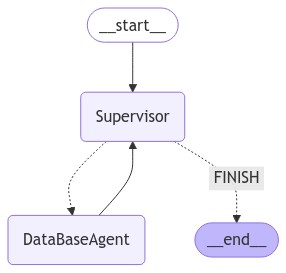

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [26]:
for s in graph.stream(
    {
        "messages": [
            # HumanMessage(content="What are top 5 best-selling products?")
            HumanMessage(content="What are top 3 best-selling products?")
            # HumanMessage(content="What is the best-selling product?")
        ]
    }
):

    if "__end__" not in s:
    
        print(s)
        if "DataBaseAgent" in s:
            data_base_agent_output = s["DataBaseAgent"]
        print("----")

{'Supervisor': {'next': 'DataBaseAgent'}}
----
{'DataBaseAgent': {'messages': [HumanMessage(content='The top 3 best-selling products are:\n\n1. **Wimmers gute Semmelknödel** - 212,968 units sold\n2. **Gorgonzola Telino** - 212,882 units sold\n3. **Steeleye Stout** - 211,790 units sold', additional_kwargs={}, response_metadata={}, name='DataBaseAgent')]}}
----
{'Supervisor': {'next': 'FINISH'}}
----


In [27]:
print(data_base_agent_output['messages'][0].content)

The top 3 best-selling products are:

1. **Wimmers gute Semmelknödel** - 212,968 units sold
2. **Gorgonzola Telino** - 212,882 units sold
3. **Steeleye Stout** - 211,790 units sold
